In [92]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import utils
from tqdm.notebook import tqdm
import xarray as xr
from torchsummary import summary
from matplotlib import cm as cmap

In [93]:
ds_CI02 = xr.load_dataset("data/CNN/CI02.xr").dropna(dim='nbtj')
ds_CI04 = xr.load_dataset("data/CNN/CI04.xr").dropna(dim='nbtj')
ds_CI06 = xr.load_dataset("data/CNN/CI06.xr").dropna(dim='nbtj')
ds_CI09 = xr.load_dataset("data/CNN/CI09.xr").dropna(dim='nbtj')
ds_CI21 = xr.load_dataset("data/CNN/CI21.xr").dropna(dim='nbtj')

data_list =[ds_CI02,ds_CI04,ds_CI06,ds_CI09,ds_CI21]

ds_CI02_norm = ds_CI02.copy()
ds_CI04_norm = ds_CI04.copy()
ds_CI06_norm = ds_CI06.copy()
ds_CI09_norm = ds_CI09.copy()
ds_CI21_norm = ds_CI21.copy()

data_norm_list =[ds_CI02_norm,ds_CI04_norm,ds_CI06_norm,ds_CI09_norm,ds_CI21_norm]

In [94]:
for k in range(5):

    vars = list(data_list[k].keys())
    vars = vars[1:9]
    for i in vars :
        v = data_list[k][i].to_numpy().reshape((data_list[k].dims['nbtj'],100))
        scaler = StandardScaler().fit(v)
        v_scaled = scaler.transform(v)
        v_scaled = v_scaled.reshape((data_list[k].dims['nbtj'],10,10))
        data_norm_list[k][i] = xr.DataArray(v_scaled,dims=['nbtj','y','x'])

In [95]:
data = xr.concat((ds_CI02_norm,ds_CI04_norm,ds_CI09_norm,ds_CI21_norm),dim='nbtj')
#data = ds_CI02_norm
test = ds_CI06_norm

In [96]:
# data = ds_CI06_norm.where(ds_CI06_norm.RX==1).dropna(dim='nbtj')
# test = ds_CI02_norm.where(ds_CI02_norm.RX==1).dropna(dim='nbtj')

In [97]:
class CustomTensorDataset(Dataset):
  def __init__(self, dataset, transform_list=None):
    data_X = dataset[['schmid','diff_schmid','misangle','work','eqStrain','eqStress','act_pr','act_py'
                      ]].to_array().to_numpy().reshape((dataset.dims['nbtj'],8,10,10))
    data_X2 = dataset[['dist_to_1neigh','volratio_an','sum_pix_g']].to_array().to_numpy().reshape((dataset.dims['nbtj'],3))
    data_y = dataset['RX'].to_numpy()
    X_tensor, X2_tensor, y_tensor = torch.tensor(data_X), torch.tensor(data_X2),torch.tensor(data_y)
    tensors = (X_tensor, X2_tensor ,y_tensor)
    assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
    self.tensors = tensors
    self.transforms = transform_list

  def __getitem__(self, index):
    x = self.tensors[0][index]

    x2 = self.tensors[1][index]

    if self.transforms:
      #for transform in self.transforms: 
      #  x = transform(x)
      x = self.transforms(x)

    y = self.tensors[2][index]

    return x, x2 ,y

  def __len__(self):
    return self.tensors[0].size(0)

In [98]:
data_train = CustomTensorDataset(data)
data_test = CustomTensorDataset(test)

In [99]:
y_test = data_test.tensors[2]

In [100]:
EPOCHS = 50
BATCH_SIZE = 16
LEARNING_RATE = 0.0001

In [101]:
trainloader = DataLoader(data_train,batch_size=BATCH_SIZE,shuffle=True)
testloader =DataLoader(data_test,batch_size=1)

In [102]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = self.conv_block(c_in=8, c_out=64, kernel_size=3)
        self.conv2 = self.conv_block(c_in=64, c_out=128, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(0.1)
        self.dense1 = nn.Linear(3, 128)
        self.prelu = nn.PReLU()
        self.dense2 = nn.Linear(256, 128)
        self.dense3 = nn.Linear(128,1)

    def forward(self, x , x2):
        #CNN
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = x.reshape((x.shape[0],x.shape[1]))
        #DNN
        x2 = self.prelu(self.dense1(x2))
        x = torch.cat((x,x2),1)
        x = self.prelu(self.dense2(x))
        x = self.prelu(self.dense3(x))
        return x

    def conv_block(self, c_in, c_out,  **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.PReLU()
        )        
        return seq_block




In [103]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [104]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

def binary_rec(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    cm = torch.zeros(2, 2)
    for t, p in zip(y_test.long(), y_pred_tag.long()):
        cm[t, p] += 1
    rec = cm[1,1] / (cm[1,1] + cm[1,0])
    rec = torch.round(rec * 100)
    
    return rec

def binary_spec(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    
    cm = torch.zeros(2, 2)
    for t, p in zip(y_test.long(), y_pred_tag.long()):
        cm[t, p] += 1

    spec = cm[0,0] / (cm[0,0] + cm[0,1])
    spec = torch.round(spec * 100)
    
    return spec

In [105]:

model = Net().float()
model.to(device)
#print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

model.train()
loss_c = []
acc_train_c = []
acc_test_c = []
rec_train_c = []
rec_test_c = []
spec_train_c = []
spec_test_c = []

for e in tqdm(range(1, EPOCHS+1)):
    epoch_loss = 0
    epoch_acc = 0
    epoch_rec = 0
    epoch_spec = 0
    for X_batch, X2_batch, y_batch in trainloader:
        X_batch, X2_batch, y_batch = X_batch.to(device), X2_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        X_batch , X2_batch = X_batch.float(), X2_batch.float()

        y_pred = model(X_batch,X2_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        rec = binary_rec(y_pred, y_batch.unsqueeze(1))
        spec = binary_spec(y_pred, y_batch.unsqueeze(1))
        
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_rec += rec.item()
        epoch_spec += spec.item()

    loss_c.append(epoch_loss/len(trainloader))
    acc_train_c.append(epoch_acc/len(trainloader))
    rec_train_c.append(epoch_rec/len(trainloader))
    spec_train_c.append(epoch_spec/len(trainloader))

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(trainloader):.5f} | Acc: {epoch_acc/len(trainloader):.3f} | Rec: {epoch_rec/len(trainloader):.3f} | Spec: {epoch_spec/len(trainloader):.3f}')

    y_pred_list = []

    model.eval()
    with torch.no_grad():
        for X_batch, X2_batch, y_batch in testloader:
            X_batch , X2_batch = X_batch.float(), X2_batch.float()
            X_batch, X2_batch = X_batch.to(device), X2_batch.to(device)
            y_test_pred = model(X_batch,X2_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

    cm = confusion_matrix(y_test, y_pred_list)

    acc_test_c.append((cm[0,0]+cm[1,1])/sum(sum(cm)))
    rec_test_c.append((cm[1,1] / (cm[1,1] + cm[1,0])))
    spec_test_c.append((cm[0,0] / (cm[0,0] + cm[0,1])))

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 001: | Loss: 22.94855 | Acc: 57.875 | Rec: 18.062 | Spec: 78.750
Epoch 002: | Loss: 7.27802 | Acc: 61.219 | Rec: 6.000 | Spec: 92.469
Epoch 003: | Loss: 8.96937 | Acc: 62.594 | Rec: 3.594 | Spec: 95.906
Epoch 004: | Loss: 5.19629 | Acc: 62.094 | Rec: 4.438 | Spec: 94.656
Epoch 005: | Loss: 6.68190 | Acc: 62.125 | Rec: 2.938 | Spec: 95.656
Epoch 006: | Loss: 7.60278 | Acc: 63.000 | Rec: 5.062 | Spec: 95.750
Epoch 007: | Loss: 9.75378 | Acc: 61.750 | Rec: 7.000 | Spec: 93.688
Epoch 008: | Loss: 3.34823 | Acc: 64.812 | Rec: 9.281 | Spec: 96.344
Epoch 009: | Loss: 7.58045 | Acc: 62.375 | Rec: 5.844 | Spec: 94.531
Epoch 010: | Loss: 2.91595 | Acc: 64.344 | Rec: 10.156 | Spec: 95.031
Epoch 011: | Loss: 4.04696 | Acc: 64.281 | Rec: 10.062 | Spec: 95.938
Epoch 012: | Loss: 5.54156 | Acc: 63.469 | Rec: 6.656 | Spec: 95.469
Epoch 013: | Loss: 3.27395 | Acc: 64.906 | Rec: 12.188 | Spec: 93.562
Epoch 014: | Loss: 3.00424 | Acc: 66.969 | Rec: 15.625 | Spec: 94.781
Epoch 015: | Loss: 5.24896 |

In [106]:
y_pred_list = []

model.eval()
with torch.no_grad():
    for X_batch, X2_batch, y_batch in tqdm(testloader):
        X_batch , X2_batch = X_batch.float(), X2_batch.float()
        X_batch, X2_batch = X_batch.to(device), X2_batch.to(device)
        y_test_pred = model(X_batch,X2_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

  0%|          | 0/216 [00:00<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x7ff7abf3faf0>
Traceback (most recent call last):
  File "/home/manceauxr/anaconda3/envs/Working_env/lib/python3.9/site-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/home/manceauxr/anaconda3/envs/Working_env/lib/python3.9/site-packages/tqdm/notebook.py", line 287, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


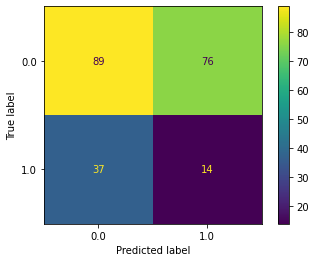

In [107]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_list)
plt.show()

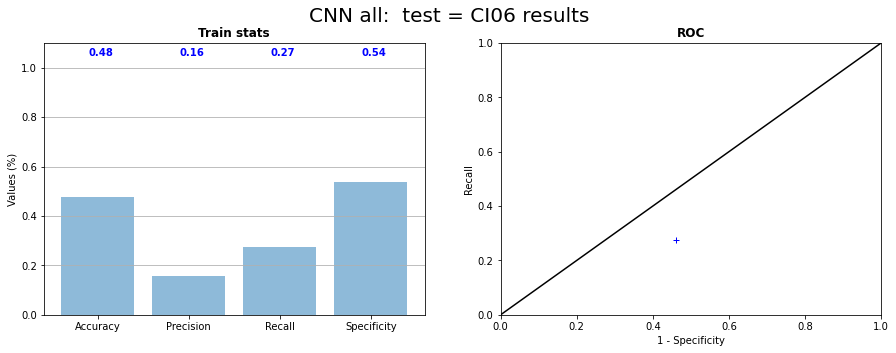

In [108]:
from sklearn import metrics
acc = metrics.accuracy_score(y_test, y_pred_list)
prec = metrics.precision_score(y_test, y_pred_list)
rec = metrics.recall_score(y_test, y_pred_list)
cm = metrics.confusion_matrix(y_test, y_pred_list)
spec = cm[0,0] / (cm[0,0] + cm[0,1])
utils.plot_lstats(acc,prec,rec,spec,model="CNN all:  test = CI06")

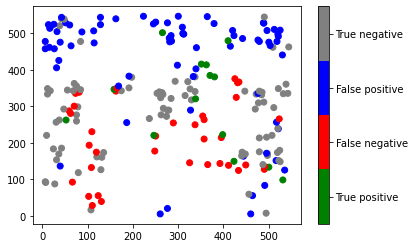

In [109]:
coords = test.coords.get('coords')
from matplotlib import colors
col = -(np.array(y_pred_list)+2*np.array(y_test))
cmap = colors.ListedColormap(['green','red','blue','gray'])
bounds=[-3.5,-2.5,-1.5,-0.5,0.5]
norm = colors.BoundaryNorm(bounds, cmap.N)

plot = plt.scatter(coords[0],coords[1],c=col,cmap=cmap,norm=norm)
cbar = plt.colorbar(plot, cmap=cmap, norm=norm, boundaries=bounds, ticks=[-3, -2, -1,0])

cbar.set_ticklabels(["True positive","False negative","False positive","True negative"])

Text(0, 0.5, 'recall')

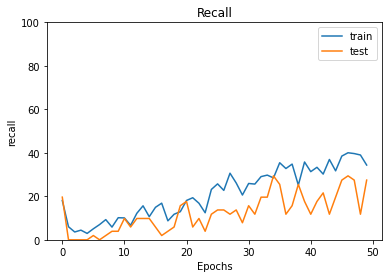

In [110]:
x = np.arange(len(rec_test_c))
plt.plot(x,rec_train_c)
plt.plot(x,np.array(rec_test_c)*100)
plt.ylim([0,100])
plt.legend(['train','test'])
plt.title("Recall")
plt.xlabel("Epochs")
plt.ylabel("recall")

Text(0, 0.5, 'specif')

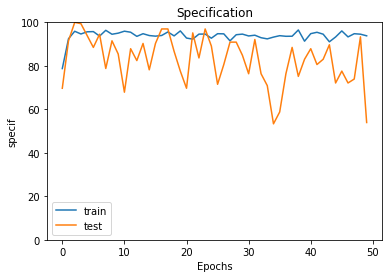

In [111]:
x = np.arange(len(rec_test_c))
plt.plot(x,spec_train_c)
plt.plot(x,np.array(spec_test_c)*100)
plt.ylim([0,100])
plt.legend(['train','test'])
plt.title("Specification")
plt.xlabel("Epochs")
plt.ylabel("specif")

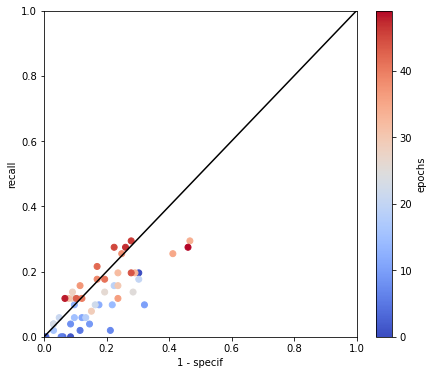

In [112]:
from matplotlib import cm as cmap
colormap = cmap.coolwarm
plt.figure(figsize=(7,6))

plt.scatter(1-np.array(spec_test_c),np.array(rec_test_c),c=np.arange(len(rec_test_c)),cmap=colormap)
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot([0,1],[0,1],"k")
cb = plt.colorbar()
cb.set_label('epochs')
plt.xlabel('1 - specif')
plt.ylabel('recall')
plt.show()
